In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, InputLayer
from keras.optimizers import Nadam

import pyedflib as plib
from pyedflib import highlevel

In [10]:
# parameters
window_size = 15 # in seconds
stride = 15 # in seconds
sampling_rate = 64 # Hz

# function to get the label for a given window
def get_label(window_start, seizure_times, pre_ictal_duration=300, post_ictal_duration=300):
    for start, end in seizure_times:
        if start - window_size/2 <= window_start < end - window_size/2:
            return [0,0,1,0] # 'ictal'
        elif start - pre_ictal_duration <= window_start < start:
            return [0,1,0,0] # 'pre-ictal'
        elif end <= window_start < end + post_ictal_duration:
            return [0,0,0,1] # 'post-ictal'
    return [1,0,0,0] # 'inter-ictal'

# function to create feature/label sets
def create_feature_label_sets(df: pd.DataFrame, seizure_times: list):
    features = []
    labels = []

    window_length = window_size * sampling_rate
    stride_length = stride * sampling_rate

    for start in range(0, len(df) - window_length, stride_length):
        window = df.iloc[start:start + window_length]
        features.append(window.values)  # Usando a série temporal como feature
        labels.append(get_label(start / sampling_rate, seizure_times))

    # Convertendo para DataFrame para fácil manipulação

    features = np.array(features)
    labels = np.array(labels)
    # print(features.shape)
    # print(labels.shape)

    # Combinando features e labels
    return features, labels


##### loading the data

In [11]:
def parse_time(hms: str): # hms = 'hh:mm:ss'
    if isinstance(hms, pd.Timestamp):
        hms = hms.strftime('%H:%M:%S')  # Converte Timestamp para string
    h, m, s = map(int, hms.split(':'))
    return h * 3600 + m * 60 + s

def generate_seizure_times(recording_start, recording_end, seiz_start, seiz_end):
    recording_start_seconds = parse_time(recording_start)
    recording_end_seconds = parse_time(recording_end)
    
    recording_start = pd.to_datetime(recording_start)
    recording_end = pd.to_datetime(recording_end)
    seiz_start = pd.to_datetime(seiz_start)
    seiz_end = pd.to_datetime(seiz_end)

    recording_duration = (recording_end - recording_start).total_seconds()

    ev_times = []
    
    # Calcular os tempos de início e fim das convulsões em segundos desde o início da gravação
    start_seconds = parse_time(seiz_start) - recording_start_seconds
    end_seconds = parse_time(seiz_end) - recording_start_seconds
    ev_times.append((start_seconds, end_seconds))

    return ev_times


In [12]:
# the strings are the start and end times of the recording and the seizure
from annotated_types import UpperCase


data_listing = [
    ['PN00/PN00-1.edf', ("19:39:33", "20:22:58"), ("19:58:36", "19:59:46")],
    ['PN00/PN00-2.edf', ("02:18:17", "02:56:19"), ("02:38:37", "02:39:31")],
    ['PN00/PN00-3.edf', ("18:15:44", "18:57:13"), ("18:28:29", "18:29:29")],
    ['PN00/PN00-4.edf', ("20:51:43", "21:26:25"), ("21:08:29", "21:09:43")],
    ['PN00/PN00-5.edf', ("22:22:04", "22:57:27"), ("22:37:08", "22:38:15")],
    ['PN05/PN05-3.edf', ("06:01:23", "08:06:57"), ("07:55:19", "07:55:49")],
    ['PN05/PN05-4.edf', ("06:38:35", "08:00:23"), ("07:38:43", "07:39:22")],
    ['PN06/PN06-4.edf', ("11:16:09", "13:12:54"), ("12:55:08", "12:56:11")],
    ['PN12/PN12-3.edf', ("08:42:35", "09:15:44"), ("08:55:27", "08:57:03")]
]

seizure_times = [generate_seizure_times(data_list[1][0], data_list[1][1],
                                     data_list[2][0], data_list[2][1])
               for data_list in data_listing]

# print(seizure_times)

all_features = []
all_labels = []

base_path = './datapoints/'
for data_list in data_listing:
    # Generate seizure times
    seizure_times = generate_seizure_times(data_list[1][0], data_list[1][1], data_list[2][0], data_list[2][1])
    
    # Load data using highlevel.read_edf (assuming data is in EDF format and highlevel.read_edf is available)
    data, data_headers, header = highlevel.read_edf(base_path + data_list[0])
    data = np.array(data)
    # print(data.shape)

    desired_order = [
        'EEG FP1',
        'EEG F3',
        'EEG C3',
        'EEG P3',
        'EEG O1',
        'EEG F7',
        'EEG T3',
        'EEG T5',
        'EEG FC1',
        'EEG FC5',
        'EEG CP1',
        'EEG CP5',
        'EEG F9',
        'EEG FZ',
        'EEG CZ',
        'EEG PZ',
        'EEG FP2',
        'EEG F4',
        'EEG C4',
        'EEG P4',
        'EEG O2',
        'EEG F8',
        'EEG T4',
        'EEG T6',
        'EEG FC2',
        'EEG FC6',
        'EEG CP2',
        'EEG CP6',
        'EEG F10'
    ]

    channel_labels = [foo['label'] for foo in data_headers]
    eeg_indices = [i for i, lab in enumerate(channel_labels)
                   if lab.startswith('EEG') 
                   and not (lab.startswith('EEG P9' or lab.startswith('EEG P10')))]
    df = pd.DataFrame(data[eeg_indices].T,
                      columns=[str(channel_labels[i]).upper() for i in eeg_indices])
    # print(df.shape)
    df = df[desired_order]
    print(df.shape)
    
    # TODO: choose the channels
    
    # Create feature and label sets for this data listing
    X, y = create_feature_label_sets(df, seizure_times)
    
    # Append the features and labels to the all_features and all_labels lists
    all_features.append(X)
    all_labels.append(y)

all_X = np.vstack(all_features)
all_y = np.concatenate(all_labels, axis=0)

print(all_X.shape)
print(all_y.shape)

print(all_y.sum(axis=0))


(168000, 29)
(147328, 29)
(160576, 29)
(134528, 29)
(137152, 29)
(483456, 29)
(315392, 29)
(449600, 29)
(127296, 29)
(2207, 960, 29)
(2207, 4)
[1814  175   38  180]


#### definindo um modelo e o treinando

In [25]:
# Model definition
model = Sequential()

model.add(InputLayer(input_shape=all_X.shape[1:])) # (960, 29)

model.add(Conv1D(filters=8, kernel_size=6, strides=1, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(Conv1D(filters=8, kernel_size=5, strides=1, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(Conv1D(filters=8, kernel_size=4, strides=1, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(all_y.shape[1], activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 955, 16)           2800      
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 477, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_10 (Conv1D)          (None, 473, 32)           2592      
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 236, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_11 (Conv1D)          (None, 233, 64)           8256      
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 116, 64)          

Compiling the model

In [26]:
# Compile the model
model.compile(optimizer=Nadam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/30
589/589 [==============================] - 6s 6ms/step - loss: 0.6950 - accuracy: 0.8170 - val_loss: 0.5480 - val_accuracy: 0.8394
Epoch 2/30
589/589 [==============================] - 2s 4ms/step - loss: 0.5423 - accuracy: 0.8181 - val_loss: 0.5201 - val_accuracy: 0.8462
Epoch 3/30
589/589 [==============================] - 2s 4ms/step - loss: 0.4831 - accuracy: 0.8357 - val_loss: 0.5032 - val_accuracy: 0.8462
Epoch 4/30
589/589 [==============================] - 2s 4ms/step - loss: 0.3883 - accuracy: 0.8618 - val_loss: 0.5914 - val_accuracy: 0.8348
Epoch 5/30
589/589 [==============================] - 2s 4ms/step - loss: 0.2922 - accuracy: 0.8935 - val_loss: 0.5998 - val_accuracy: 0.8213
Epoch 6/30
589/589 [==============================] - 2s 4ms/step - loss: 0.2440 - accuracy: 0.9082 - val_loss: 0.7751 - val_accuracy: 0.8032
Epoch 7/30
589/589 [==============================] - 2s 4ms/step - loss: 0.1313 - accuracy: 0.9535 - val_loss: 1.1047 - val_accuracy: 0.7670
Epoch 

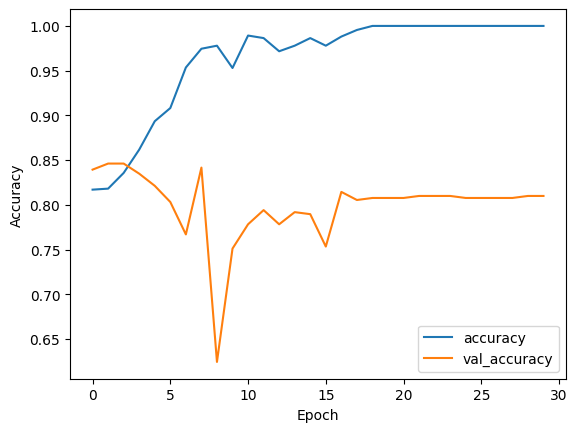

In [27]:
# split the data into training and validation sets
from cProfile import label
from sklearn.model_selection import train_test_split
(x_train, x_val, y_train, y_val) = train_test_split(all_X, all_y, test_size=0.2)

# Train the model
history = model.fit(x_train, y_train, epochs=30, batch_size=3, validation_data=(x_val, y_val))

plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.plot(history.history['loss'])
plt.show()

# Evaluate the model
# loss, accuracy = model.evaluate(X_val, y_val)
# print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Now testing the model on untrained data (test data)

In [19]:
# loading the test data
seizure_times2 = generate_seizure_times("14:20:23", "16:34:28", "16:20:44", "16:21:48")
    
# Load data using highlevel.read_edf (assuming data is in EDF format and highlevel.read_edf is available)
data2, data_headers2, header2 = highlevel.read_edf(base_path + 'PN09/PN09-3.edf')
data = np.array(data)
# print(data.shape)

desired_order = [
    'EEG FP1',
    'EEG F3',
    'EEG C3',
    'EEG P3',
    'EEG O1',
    'EEG F7',
    'EEG T3',
    'EEG T5',
    'EEG FC1',
    'EEG FC5',
    'EEG CP1',
    'EEG CP5',
    'EEG F9',
    'EEG FZ',
    'EEG CZ',
    'EEG PZ',
    'EEG FP2',
    'EEG F4',
    'EEG C4',
    'EEG P4',
    'EEG O2',
    'EEG F8',
    'EEG T4',
    'EEG T6',
    'EEG FC2',
    'EEG FC6',
    'EEG CP2',
    'EEG CP6',
    'EEG F10'
]

channel_labels = [foo['label'] for foo in data_headers]
eeg_indices = [i for i, lab in enumerate(channel_labels)
                if lab.startswith('EEG') 
                and not (lab.startswith('EEG P9' or lab.startswith('EEG P10')))]
df = pd.DataFrame(data[eeg_indices].T,
                    columns=[str(channel_labels[i]).upper() for i in eeg_indices])
# print(df.shape)
df = df[desired_order]
print(df.shape)

# TODO: choose the channels

# Create feature and label sets for this data listing
X, y = create_feature_label_sets(df, seizure_times)

# Append the features and labels to the all_features and all_labels lists
all_features.append(X)
all_labels.append(y)

all_X2 = np.vstack(all_features)
all_y2 = np.concatenate(all_labels, axis=0)

print(all_X2.shape)
print(all_y2.shape)

print(all_y2.sum(axis=0))


(127296, 29)
(2603, 960, 29)
(2603, 4)
[2072  232   59  240]


82/82 [==============================] - 0s 2ms/step


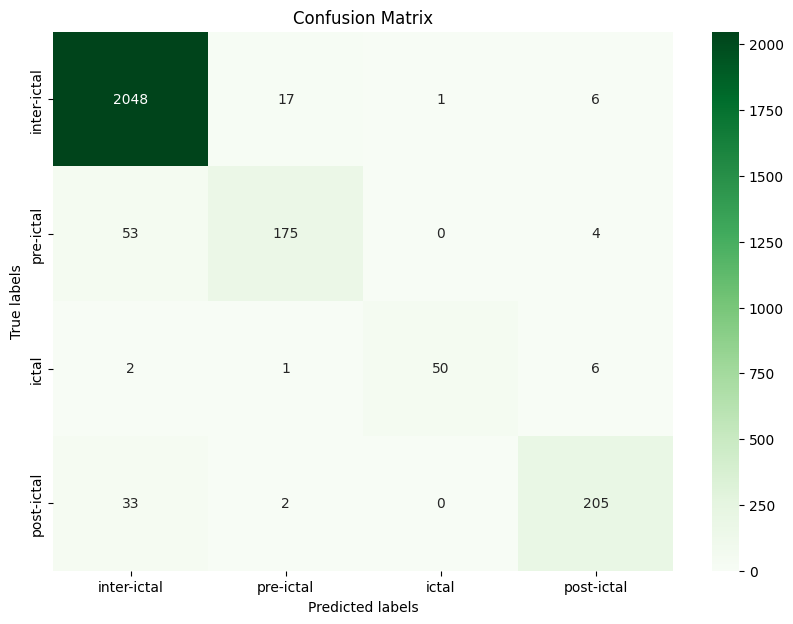

In [23]:
# making the predictions
preds = model.predict(all_X2)

# plotting the results
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming preds are probabilities, use argmax to convert to class labels
pred_labels = np.argmax(preds, axis=1)
true_labels = np.argmax(all_y2, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

class_labels = ['inter-ictal', 'pre-ictal', 'ictal', 'post-ictal']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

